In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import random
import typhon as ty
import datetime

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

## ERA5 randomn profile selection

In [2]:
ERA5_fields = xr.open_mfdataset('/home/mringel/lwp_project/mringel/data/era5/field_*_v4.nc')

# subselect ERA5 data at 200 randomly choosen timestamps
ERA5_fields = ERA5_fields.isel(
    time = sorted(random.sample(np.arange(len(ERA5_fields.time)).tolist(),200)),
    drop = True)

# average ERA5 data over these 200 timestamps to identify ocean gridcells which are continously sea ice free
ERA5_avg_fields = ERA5_fields.mean(dim='time')
ERA5_avg_fields = ERA5_avg_fields.compute()
ERA5_avg_fields = ERA5_avg_fields.where((ERA5_avg_fields.var31==0.)&(ERA5_avg_fields.var172==0.),drop=False)

# get indices of these ocean and sea ice free gridcells
# select a randomn choice of 10 gridcell indices 
# the coordinates of these 10 gridcells will not change 
si_free_ocean_coordinates = np.argwhere(~np.isnan(ERA5_avg_fields.var78.values))
si_free_ocean_coordinates = si_free_ocean_coordinates[sorted(random.sample(np.arange(len(si_free_ocean_coordinates)).tolist(),10))]

In [3]:
ERA5_rndm_subsample = ERA5_fields.isel(
    time = 0,
    lon = si_free_ocean_coordinates[0,1],
    lat = si_free_ocean_coordinates[0,0],
    drop = False
)

for i in range(1,len(si_free_ocean_coordinates)):

    ERA5_at_t = ERA5_fields.isel(
        time = 0,
        lon = si_free_ocean_coordinates[i,1],
        lat = si_free_ocean_coordinates[i,0],
        drop = False
        )
        
    ERA5_rndm_subsample = xr.concat([ERA5_rndm_subsample,ERA5_at_t],dim='time')
    ERA5_at_t.close()


for t in range(1,ERA5_fields.time.size):
    for i in range(0,len(si_free_ocean_coordinates)):

        ERA5_at_t = ERA5_fields.isel(
            time = t,
            lon = si_free_ocean_coordinates[i,1],
            lat = si_free_ocean_coordinates[i,0],
            drop = False
            )
        
        ERA5_rndm_subsample = xr.concat([ERA5_rndm_subsample,ERA5_at_t],dim='time')
        ERA5_at_t.close()

ERA5_rndm_subsample = ERA5_rndm_subsample.rename(
    {'var31':'ci',
     'var34':'sst',
     'var134':'sp',
     'var137':'tcwv',
     'var151':'msl',
     'var165':'u10',
     'var166':'v10',
     'var235':'skt',
     'var78':'tclw',
     'var79':'tciw',
     'var129':'z',
     'var172':'lsm',
     })

#### Saving profile selection

In [6]:
ERA5_rndm_subsample = ERA5_rndm_subsample.compute()
ERA5_rndm_subsample.to_netcdf('/home/mringel/lwp_project/mringel/data/era5/ERA5_2000_rndm_profiles.nc')

: 

#### Plot LWP and daytime distribution of random profile selection

In [2]:
ERA5_rndm_subsample = xr.open_dataset('/home/mringel/lwp_project/mringel/data/era5/ERA5_2000_rndm_profiles.nc')
ERA5_along_flight = xr.open_dataset('/home/mringel/lwp_project/mringel/data/lwp_collocated/era5_alongFlights/all_campaigns_ERA5_lwp_v2.nc')

Text(0.45, -0.05, 'LWP [g m$^{-2}$]')

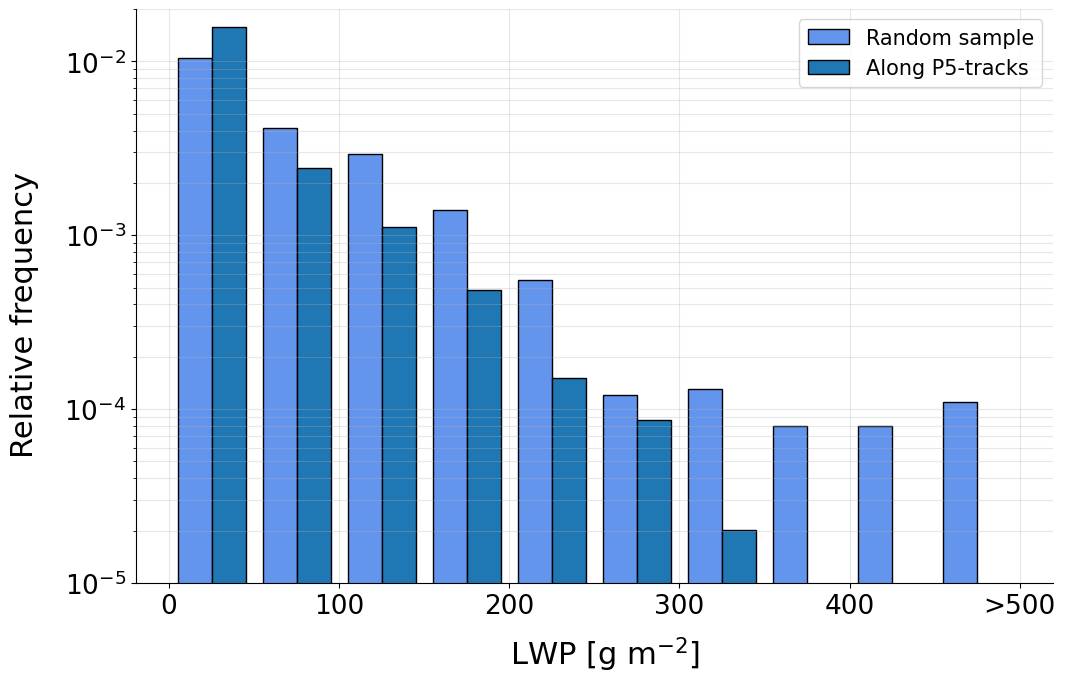

In [3]:
fig, ax = plt.subplots()

lwp_range = [0,500]
bins = 10

ax.hist(
    [np.clip(ERA5_rndm_subsample.tclw*1000,lwp_range[0],lwp_range[1]),np.clip(ERA5_along_flight.lwp*1000,lwp_range[0],lwp_range[1])],
    bins=bins,color=['cornflowerblue','C0'],ec='black',label=['Random sample','Along P5-tracks'],density=True)
ax.set_yscale('log')
ax.set_ylim(bottom=10**(-5),top=2*10**(-2))
ax.set_xticks(np.array([0,100,200,300,400,500]))
ax.set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))
ax.tick_params(axis="both", labelsize=19)
ax.grid(alpha=0.3,which='both',axis="both")
ax.legend()

fig.text(-0.05, 0.5,'Relative frequency',rotation=90,fontsize=22,va='center')
fig.text(0.45, -0.05,'LWP [g m$^{-2}$]',fontsize=22,va='center')

#plt.savefig('/home/mringel/lwp_project/figures/retrieval_in_modelworld/era5_rndm_profiles_histogram_lwp_vs_alongtrack.png',
#            bbox_inches='tight',dpi=200)

Text(0.5, 0, 'Time (UTC)')

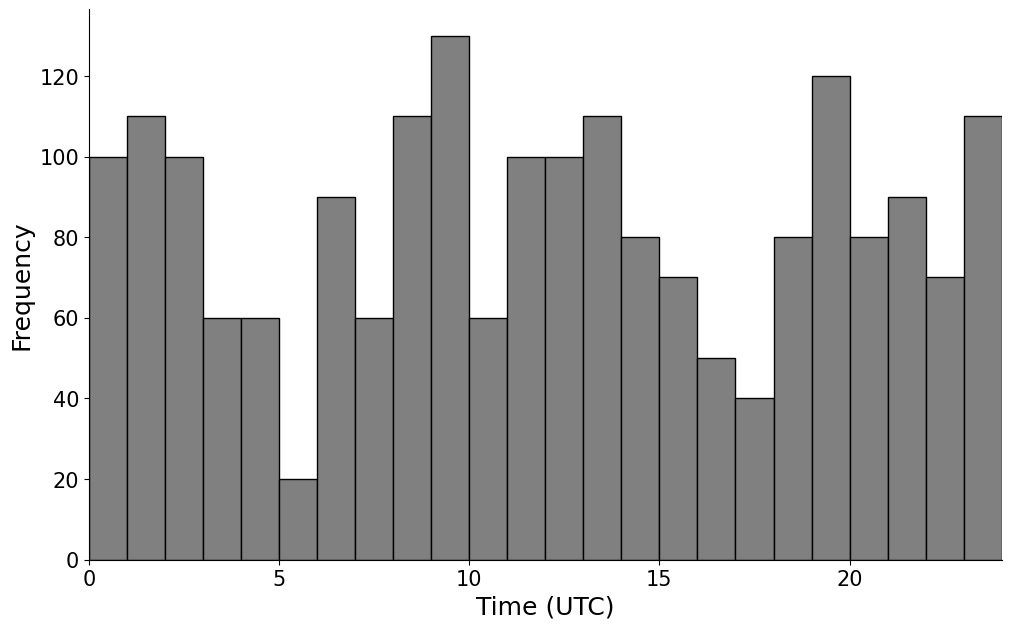

In [6]:
def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.datetime.utcfromtimestamp(timestamp)

datetimes = ERA5_rndm_subsample.time.values
numtimes = np.array([int(to_datetime(datetimes[i]).time().strftime('%H%M%S')) for i in range(len(datetimes))])

fig, axs = plt.subplots()

axs.hist(numtimes/10000,bins=24,range=(0,24),color='grey',ec='black')
axs.set_xlim(0,24)
axs.set_ylabel('Frequency')
axs.set_xlabel('Time (UTC)')

#plt.savefig('/home/mringel/lwp_project/figures/retrieval_in_modelworld/era5_rndm_profiles_timestamps.png',
#            bbox_inches='tight',dpi=200)

#### Plot coordinates of random profiles

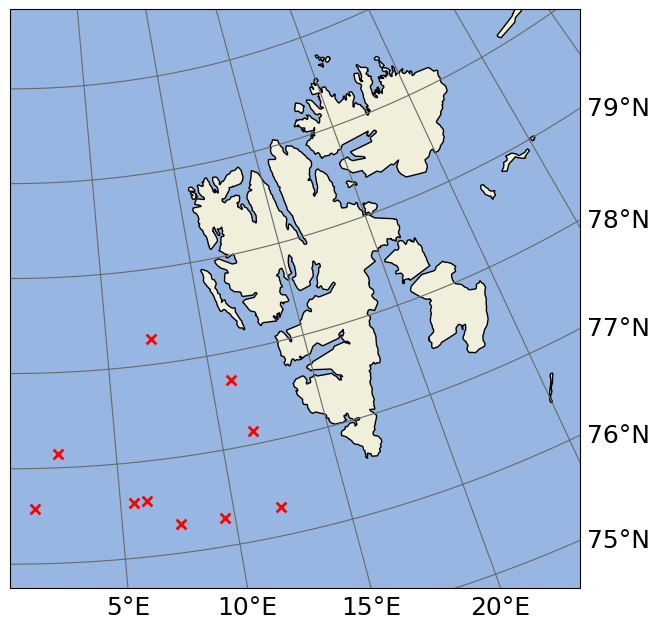

In [7]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()})

# set map extent
axs.set_extent([0., 25.0, 75.75, 81.0], crs=ccrs.PlateCarree())

# plot land features
axs.add_feature(cartopy.feature.OCEAN, zorder=0)
axs.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

# plot gridlines & labels
gl = axs.gridlines(color='dimgray',draw_labels=True,
                   x_inline=False, y_inline=False,
                   zorder=1,transform=ccrs.PlateCarree())
gl.rotate_labels = False
gl.xlabel_style={'size': 18}
gl.ylabel_style={'size': 18}
gl.top_labels = False
gl.left_labels = False

ERA5_rndm_subsample_t = ERA5_rndm_subsample.sel(time=ERA5_rndm_subsample.time.values[0],drop=True)

axs.scatter(ERA5_rndm_subsample_t.lon,ERA5_rndm_subsample_t.lat,
            color='red',
            #label='P5 tracks',
            #alpha=0.15,
            s=50,
            zorder=2,
            marker='x',
            transform=ccrs.PlateCarree())

#plt.savefig('/home/mringel/lwp_project/figures/retrieval_in_modelworld/era5_rndm_profiles_coordinates.png',
#            bbox_inches='tight',dpi=200)